# Augmenting LLM NIMs with BioNeMo through LangChain

In this notebook, we will take the first step in building a chatbot which has the ability to call on BioNeMo tools. This demo will combine various technologies and use an NVIDIA LLM NIM (Llama 3.1) as an orchestrator and a BioNeMo NIM (ESMFold) as the tool. The orchestration framework in this demo is LangChain/LangGraph.

## Setup

Start by importing required libraries:

In [94]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
from langchain_core.pydantic_v1 import Field
from langchain_core.tools import tool
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langgraph.prebuilt import create_react_agent
import requests

We can first explore which NVIDIA LLM NIMs support tool calling and structured outputs. This will print a list of our current options.

In [96]:
tool_models = [model for model in ChatNVIDIA.get_available_models() if model.supports_tools]
for elem in tool_models:
    print(elem)

id='meta/llama-3.1-8b-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True base_model=None
id='meta/llama-3.2-3b-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True base_model=None
id='mistralai/mistral-large-2-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True base_model=None
id='meta/llama-3.1-70b-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True base_model=None
id='meta/llama-3.1-405b-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True base_model=None
id='nv-mistralai/mistral-nemo-12b-instruct' model_type='chat' client='ChatNVIDIA' endpoint=None aliases=None supports_tools=True supports_structured_output=True bas

From this list, we'll go with `llama-3.1-70b-instruct`. First, set your API key:

In [97]:
API_KEY = "Enter API Key here"

## Access Base LLM

We'll set up the LLM through LangChain's ChatNVIDIA functionality, which provides an interface to NVIDIA NIM chat models. It offers connection to both hosted and local NIMs (Mistral, Llama, etc.), tool calling capabilities, streaming functionality, etc.

In [ ]:
# NVIDIA-hosted API endpoint
model = ChatNVIDIA(model="meta/llama-3.1-70b-instruct", api_key=API_KEY)

# Locally-hosted model example
# model = ChatNVIDIA(base_url="http://3.145.171.211:8000/v1", model_name="meta/llama-3.1-8b-instruct") 

Let's try a simple question about proteins:

In [100]:
result = model.invoke("What are protiens made of?")
print(result.content)

Proteins are made up of smaller units called amino acids, which are linked together in a chain. These amino acid chains are the building blocks of proteins.

There are 20 different amino acids that are commonly found in nature, and they are the foundation of all proteins. These amino acids include:

1. Alanine (Ala or A)
2. Arginine (Arg or R)
3. Asparagine (Asn or N)
4. Aspartic acid (Asp or D)
5. Cysteine (Cys or C)
6. Glutamic acid (Glu or E)
7. Glutamine (Gln or Q)
8. Glycine (Gly or G)
9. Histidine (His or H)
10. Isoleucine (Ile or I)
11. Leucine (Leu or L)
12. Lysine (Lys or K)
13. Methionine (Met or M)
14. Phenylalanine (Phe or F)
15. Proline (Pro or P)
16. Serine (Ser or S)
17. Threonine (Thr or T)
18. Tryptophan (Trp or W)
19. Tyrosine (Tyr or Y)
20. Valine (Val or V)

When these amino acids are linked together in a chain, they form a protein. The sequence of amino acids in a protein is known as the primary structure, and it determines the protein's three-dimensional shape and

We can see that the model gives a fair answer. Now, let's ask the model to predict the 3D structure of a protein sequence:

In [101]:
result = model.invoke("What is the structure of protein sequence MALLWMRLLPLLALLALWGPD?")
print(result.content)

To determine the structure of a protein sequence, we would typically rely on various bioinformatics tools and structural prediction algorithms. I'll provide a brief overview of the steps involved and an educated guess based on general protein structure principles.

Protein sequence: MALLWMRLLPLLALLALWGPD


## Step 1: Analyzing the sequence
The given sequence appears to be a hydrophobic protein sequence, likely from a membrane-bound protein or a protein with a high propensity to form amphipathic helices.

## Step 2: Predicting secondary structure
Using a secondary structure prediction tool, such as PSIPRED or JPred, we can predict the likely secondary structure elements (e.g., alpha-helices, beta-sheets) within the sequence.

## Step 3: Prediction output
Assuming a prediction tool has been applied, we might see a result indicating that the sequence is rich in alpha-helical structure, with some segments predicted to adopt a beta-sheet conformation.

## Step 4: Tertiary structure predicti

Here, the model outputs the steps involved in structure prediction and also suggests that the structure will be alpha-helical with possible beta-sheet elements. But what if we want something more accurate? We can connect the LLM to a structure prediction tool such as ESMFold so that it can actually predict the atomic-level 3D structure when prompted.

## Create the Orchestration Agent 

Now, we want to give the LLM access to the BioNeMo NIM, ESMFold, for protein structure prediction. Let's define a function to invoke the ESMFold NIM, either the NVIDIA-hosted version (using credits on [build.nvidia.com](build.nvidia.com)) or a self-hosted version.

In [102]:
def invoke_esmfold_nim(sequence):
    # Code for NVIDIA-hosted model
    invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/esmfold"
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Accept": "application/json",
    }

    # Code for locally-hosted model
    # invoke_url = "http://3.145.171.211:8008/protein-structure/esmfold/predict"
    # headers = {
    #     "accept": "application/json",
    #     "Content-Type": "application/json"
    # }

    payload = {
        "sequence": sequence
    }
    
    session = requests.Session()
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_body = response.json()
    return(response_body)


Let's also write a function that saves ESMFold output locally as a pdb file.

In [103]:
def save_esmfold_output(response_json, output_file="proteins/protein.pdb"):

    # Extract the PDB content from the response
    pdb_content = response_json["pdbs"][0]
    #print("PDB CONTENT", pdb_content)

    # Find the start of the MODEL section
    model_start = pdb_content.find("MODEL")
    
    # Write the cleaned PDB content to a file
    with open(output_file, "w") as f:
        f.write(pdb_content[model_start:])

Now, let's bring the above functions together in a tool which we will make available to the LLM. We give the function the `@tool` decorator, a descriptive docstring, and argument descriptions.

In [113]:
@tool(return_direct=True)
def predict_protein_structure(
    sequence: str = Field(..., description="The amino acid sequence of the protein")
) -> str:
    """Predict the 3D structure of a protein from its amino acid sequence."""

    # Step 1
    response_body = invoke_esmfold_nim(sequence)

    # Step 2
    save_esmfold_output(response_body)

    # Output Text
    default_head = f'For the sequence {sequence}, below are the atomic coordinates of the predicted 3D structure. I have also saved a copy of the outputted PDB file locally.\n'
    full_response = default_head + str(response_body)
    
    return full_response

We can now bring it all together by defining an agent as the combination of the model and the tool(s) it has access to. This is done through LangGraph's `create_react_agent()` functionality which creates an agent that uses ReAct prompting based on the paper, [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/pdf/2210.03629). Under the hood, the `.bind_tools(tools)` functionality is called.

The LangChain Framework is designed in such a way that when we bring the tool and model together, the model will have access to not just the tool itself, but the tool description (docstring), expected input/output formats, and the tool name. When this becomes part of the model's context, it will allow the model to understand what the tool does, when to use it, and how to format tool calls correctly (including what inputs to pass into the tool, based on the user's prompt).

In [114]:
agent = create_react_agent(model, tools=[predict_protein_structure])

We can now invoke the agent with a query!

In [115]:
def process_query(query: str):
    result = agent.invoke({
        "messages": [{"role": "user", "content": query}]
    })
    return result["messages"][-1].content

# Ask the same question again
protein_query = "What is the structure of protein sequence MALLWMRLLPLLALLALWGPD?"
result = process_query(protein_query)
#print(result)
print(result[:1500]) # truncate output

For the sequence MALLWMRLLPLLALLALWGPD, below are the atomic coordinates of the predicted 3D structure. I have also saved a copy of the outputted PDB file locally.
{'pdbs': ['PARENT N/A                                                                      \nMODEL     1                                                                     \nATOM      1  N   MET A   1     -10.468  -4.505 -10.957  1.00 74.34           N  \nATOM      2  CA  MET A   1     -10.264  -3.404 -10.020  1.00 75.18           C  \nATOM      3  C   MET A   1      -9.672  -3.909  -8.709  1.00 76.65           C  \nATOM      4  CB  MET A   1     -11.581  -2.673  -9.754  1.00 69.38           C  \nATOM      5  O   MET A   1      -8.814  -3.252  -8.116  1.00 74.45           O  \nATOM      6  CG  MET A   1     -11.911  -1.608 -10.786  1.00 63.38           C  \nATOM      7  SD  MET A   1     -11.705   0.094 -10.132  1.00 60.39           S  \nATOM      8  CE  MET A   1     -10.775   0.851 -11.493  1.00 54.19           C  \nATOM 

It works! The agent deemed tool usage as necessary, successfully called the ESMFold NIM, and parsed the user prompt such that only the amino acid sequence, `MALLWMRLLPLLALLALWGPD`, was inputted. We've truncated the output length for this demo, but the tool call was also built to save a pdb file locally. Let's load that file and visualize the protein structure.

In [ ]:
import nglview as nv
from Bio import PDB
from IPython.display import display, Image
import time
import threading

# Load and display the saved structure
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("protein", "proteins/protein.pdb")
view = nv.show_biopython(structure)

view

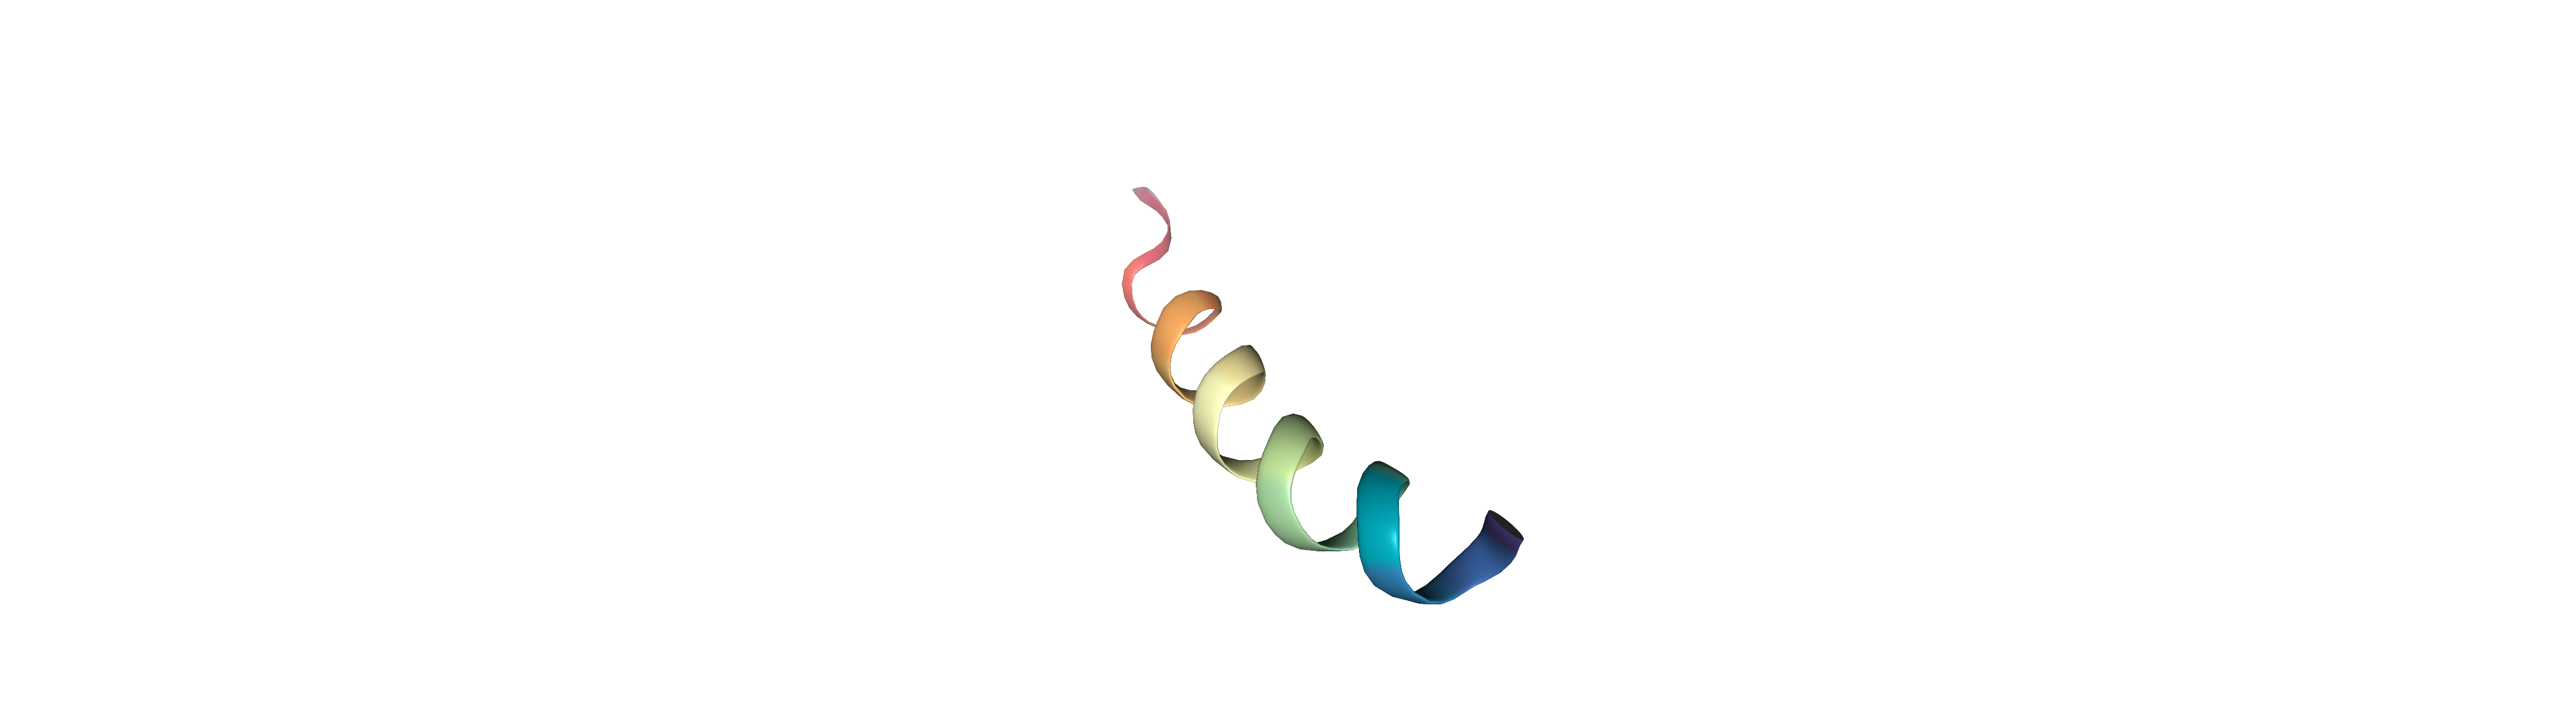

In [117]:
# Save displayed image
def save_image(view):
    img = view.render_image()
    while not img.value:
        time.sleep(0.1)
    with open("images/protein.png", "wb") as f:
        f.write(img.value)

thread = threading.Thread(target=save_image, args=(view,))
thread.daemon = True
thread.start()

# View saved image
display(Image(filename='images/protein.png'))

It is worth confirming that the agent is intelligent enough to determine when to invoke the tool (not calling the tool by default). We can check that by asking it a general question about proteins (not involving structure prediction of a specific protein) and ensuring it does not wrongly call the tool:

In [118]:
protein_query = "What are proteins made of?"
result = process_query(protein_query)
print(result)

Proteins are made up of amino acids, which are the building blocks of proteins. Amino acids are organic compounds that contain a central carbon atom bonded to an amino group (-NH2), a carboxyl group (-COOH), a hydrogen atom, and a side chain (also known as a residue) that varies depending on the specific amino acid. The sequence of amino acids in a protein determines its structure and function. There are 20 different amino acids that the human body uses to build proteins.


It is worth noting that in most tool use-cases, we want the orchestrator model not to directly output the tool's result, but to have access to the tool's result when forming an answer. For example, if a weather tool returned local weather in a specific format (e.g. `{"city":"San Francisco", "temperature":"62 degrees"}`), the orchestrator accessing this information should turn it into something like `It is currently 62 degrees in San Francisco.` In our case, however, we wanted to directly return the exact predicted protein structure when ESMFold was invoked. This behavior is handled by the `@tool` decorator:

`@tool:`
* The tool's output is passed back to the LLM for further processing.
* The LLM can generate additional text or summaries based on the tool's output.
* Allows for continued agent reasoning and potential additional tool calls.

`@tool(return_direct=True):`
* The tool's output is returned directly to the user without any further LLM processing.
* Stops the agent's reasoning loop immediately after the tool executes.

In our case, we used the latter. This is shown below through directly printing the verbose output of `agent.invoke()`, which shows the reasoning loop.


In [119]:
full_protein_result = agent.invoke({"messages": [{"role": "user", "content": "What is the structure of protein sequence MALLWW?"}]})
full_protein_result

{'messages': [HumanMessage(content='What is the structure of protein sequence MALLWW?', additional_kwargs={}, response_metadata={}, id='82453837-120d-412a-b18e-f0d1acc75ce6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-a731111f10b54f10b3ea74b694e40ef0', 'type': 'function', 'function': {'name': 'predict_protein_structure', 'arguments': '{"sequence": "MALLWW"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-a731111f10b54f10b3ea74b694e40ef0', 'type': 'function', 'function': {'name': 'predict_protein_structure', 'arguments': '{"sequence": "MALLWW"}'}}], 'token_usage': {'prompt_tokens': 264, 'total_tokens': 279, 'completion_tokens': 15}, 'finish_reason': 'tool_calls', 'model_name': 'nvdev/meta/llama-3.1-70b-instruct'}, id='run-256f468c-df93-4549-b379-efdd2b57a2ea-0', tool_calls=[{'name': 'predict_protein_structure', 'args': {'sequence': 'MALLWW'}, 'id': 'chatcmpl-tool-a731111f10b54f10b3ea74b694e40ef0', 

As seen, the agent's reasoning loop goes through the following steps, ending directly with the tool call:
* Human prompt
* Agent response (in this case, choosing to make a tool call and parsing the prompt accordingly)
* Tool invocation

If we don't want this to happen (and instead desire an agent reasoning step after the tool invocation), we can edit the tool decorator accordingly:

In [120]:
@tool
def predict_protein_structure(
    sequence: str = Field(..., description="The amino acid sequence of the protein")
) -> str:
    """Predict the 3D structure of a protein from its amino acid sequence."""

    # Step 1
    response_body = invoke_esmfold_nim(sequence)

    # Step 2
    save_esmfold_output(response_body)

    # Output Text
    default_head = f'For the sequence {sequence}, below are the atomic coordinates of the predicted 3D structure. I have also saved a copy of the outputted PDB file locally.\n'
    full_response = default_head + str(response_body)
    
    return full_response

agent = create_react_agent(model, tools=[predict_protein_structure])

full_protein_result = agent.invoke({"messages": [{"role": "user", "content": "What is the structure of protein sequence MALLWW?"}]})
full_protein_result

{'messages': [HumanMessage(content='What is the structure of protein sequence MALLWW?', additional_kwargs={}, response_metadata={}, id='6462bcc7-8325-4cde-b897-16cf12cce2c6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-f35236709cf2468186f5ab7dba9aaddd', 'type': 'function', 'function': {'name': 'predict_protein_structure', 'arguments': '{"sequence": "MALLWW"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-f35236709cf2468186f5ab7dba9aaddd', 'type': 'function', 'function': {'name': 'predict_protein_structure', 'arguments': '{"sequence": "MALLWW"}'}}], 'token_usage': {'prompt_tokens': 264, 'total_tokens': 279, 'completion_tokens': 15}, 'finish_reason': 'tool_calls', 'model_name': 'nvdev/meta/llama-3.1-70b-instruct'}, id='run-7bf631e6-eba2-49e8-8cdb-8d8f224f9420-0', tool_calls=[{'name': 'predict_protein_structure', 'args': {'sequence': 'MALLWW'}, 'id': 'chatcmpl-tool-f35236709cf2468186f5ab7dba9aaddd', 

Now, the reasoning steps are:
* Human prompt
* Agent response (in this case, choosing to make a tool call and parsing the prompt accordingly)
* Tool invocation
* Agent response

The orchestrator now sees the ESMFold output, but rather than stopping and directly printing it, it takes an extra step, analyzing and summarizing the output. In some cases, it notes the number of atoms seen in the predicted 3D structure, counts the Hydrogen atoms, etc. In this case, it gives a general description based on the pdb file.

The decision of whether or not to directly stop at the tool's output is highly dependent on the use-case.